In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pickle
import os

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

In [2]:
from IPython.display import display as print
from core_lib import plot_dataset,r2_loss,get_predict_ks, get_dcdt_func_for_sunode
from core_lib import get_predict_starts
from core_lib import get_model, get_model2, distance_func, MY_EPSILON
from core_lib import MyDataset


import core_lib
import importlib
importlib.reload(core_lib);

In [3]:
db_csv_path = "dataset/data.csv"

# 忽略部分数据的结果，但是忽略的数据正常
# idata_save_path = "runtime/pts/research-fake-data-success.dt"

# 忽略部分数据的结果，但是忽略的数据不正常
idata_save_path = "runtime/pts/research-fake-data-randome-fake-success.dt"

dataset_ori = core_lib.MyDataset(db_csv_path)
df_ori = dataset_ori.get_df()
cct_names, rates_names, error_names = dataset_ori.get_var_col_names()
c0 = df_ori[cct_names].iloc[0].values


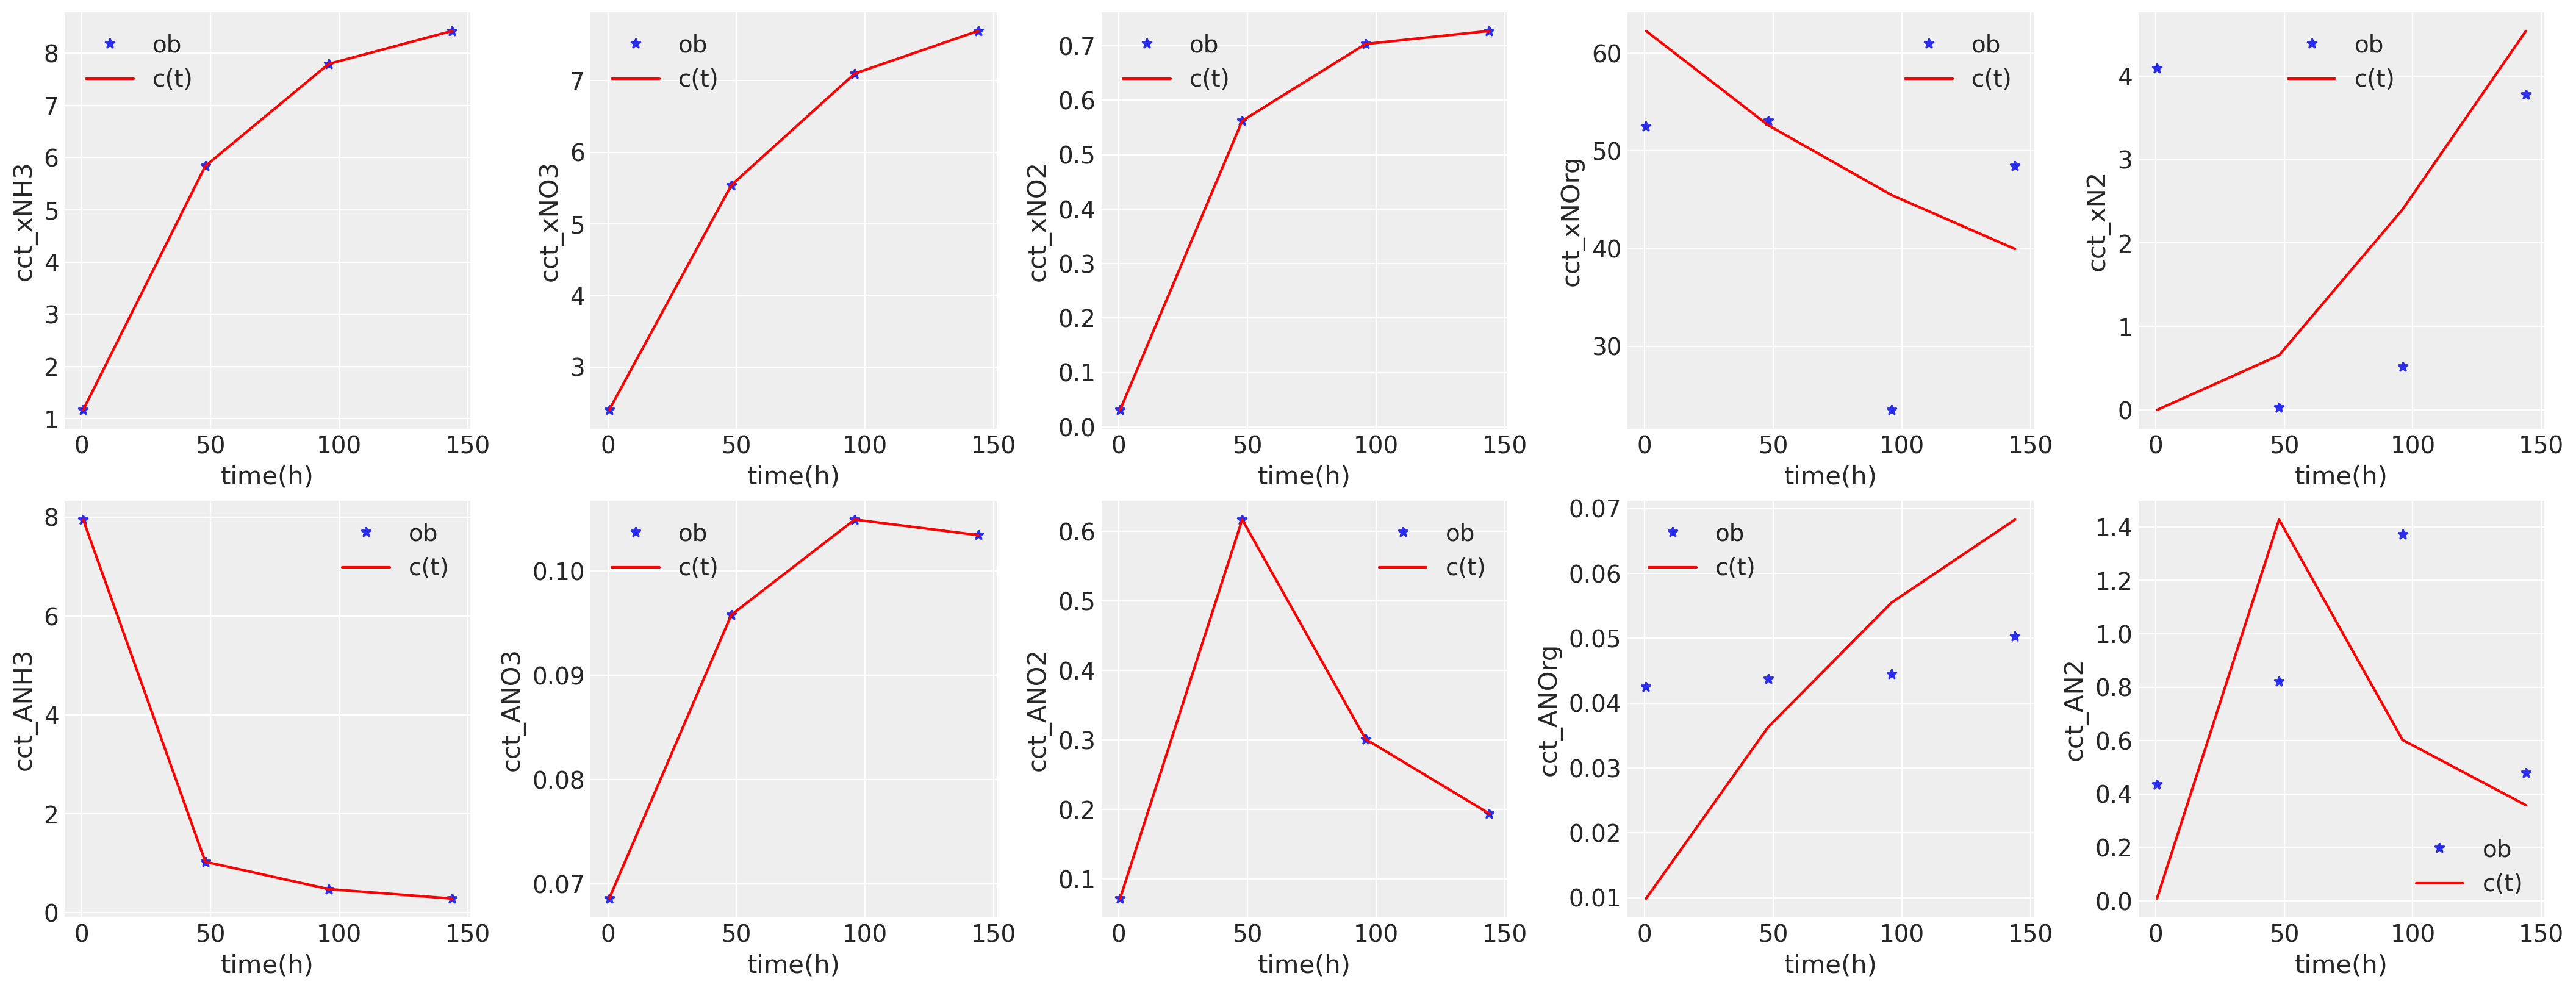

In [4]:
# 假设都是一级动力学
k_kinetics = np.repeat(1, 11).astype(np.uint8)
# k_kinetics = np.array([0,0,0,0,1,1,0,0,1,1,0]).astype(np.uint8)
ks = np.array([0.00071942, 0.00269696, 0.00498945, 0.00444931, 0.00571299, 0.00801272, 0.00131931, 0.00319959, 0.00415571, 0.00228432, 0.00177611])
#  =======================================================
import copy

# t_eval = np.linspace(0, 150, 100)
t_eval = np.array([0.5, 48, 96, 144])

# 初始化原始数据
dataset_ori = core_lib.MyDataset(db_csv_path)

# 初始化正确的模拟数据
dataset_sim = core_lib.MyDataset(db_csv_path)
dataset_sim.set_as_sim_dataset(t_eval, c0, t0=0.5, args=(ks, k_kinetics))
df = dataset_sim.get_df()

# 由模拟数据，生成fake字段
dataset_fake = copy.deepcopy(dataset_sim)
fake_colums = dataset_fake.get_fake_cct_names()
dataset_fake.set_random(c_names=fake_colums)

dataset = dataset_fake

df = dataset.get_df()
cct_names, rates_names, error_names = dataset.get_var_col_names()
c0 = df[cct_names].iloc[0].values
plot_dataset(dataset, dataset_sim)

In [12]:
k_kinetics

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=uint8)

In [5]:

mcmc_model = core_lib.get_model(dataset_sim, t_eval, k_kinetics, distance=core_lib.distance_func_v2, epsilon=core_lib.MY_EPSILON_TEE, k_sigma_priors=0.01, kf_type=0, c0_type=0)



[1.16666667e+00 2.39880952e+00 3.11000000e-02 6.22850000e+01
 7.11000000e-05 7.94863498e+00 6.85792330e-02 7.23100000e-02
 9.85666700e-03 8.32000000e-03]


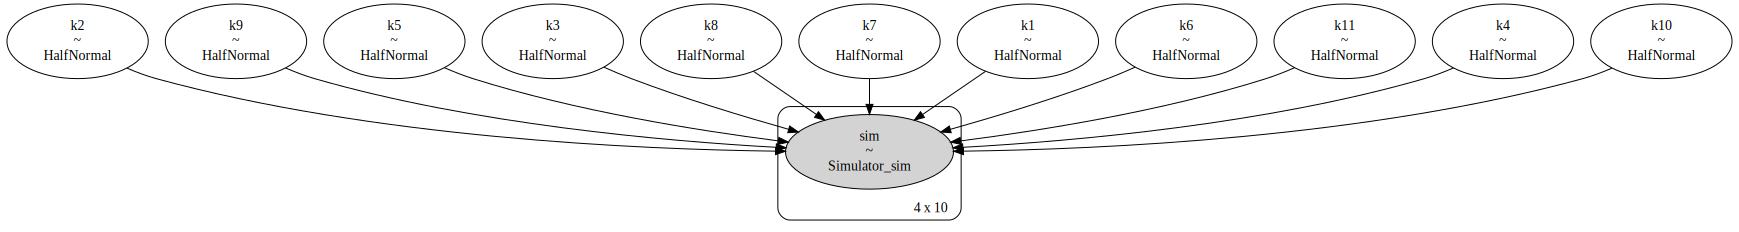

In [6]:
# print(get_format_time(),idata_save_path)
# print(ks, c0)
pm.model_to_graphviz(mcmc_model)

In [ ]:
print(idata_save_path)
# idata_lv = pickle.load(open(idata_save_path, 'rb'))
# 
os.makedirs(os.path.dirname(idata_save_path), exist_ok=True)
idata_lv = pm.sample_smc(draws=2000, chains=4, model=mcmc_model, progressbar=True)
pickle.dump(idata_lv,open(idata_save_path, 'wb'))

In [8]:
# az.plot_trace(idata_lv, kind="rank_vlines");
df[cct_names]

,xNH3,xNO3,xNO2,xNOrg,xN2,ANH3,ANO3,ANO2,ANOrg,AN2
0,1.166667,2.398810,0.031100,52.549956,4.090595,7.948635,0.068579,0.072310,0.042485,0.435518
1,5.837087,5.539301,0.562177,53.102717,0.032941,1.032210,0.095807,0.616771,0.043699,0.822914
2,7.792909,7.098859,0.703303,23.472771,0.519367,0.478821,0.104952,0.301327,0.044478,1.373254
3,8.424422,7.693928,0.727245,48.478017,3.780137,0.288168,0.103458,0.194543,0.050295,0.479741


In [9]:
print(az.summary(idata_lv, round_to=10))
print(ks)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
k1,0.002965,0.002653,0.000068,0.007605,0.000127,0.000090,189.478303,2015.044195,1.021114
k2,0.003510,0.000916,0.001901,0.005239,0.000017,0.000013,3141.486703,1977.180788,1.001503
k3,0.008892,0.006104,0.000356,0.020015,0.000110,0.000078,2584.135414,1795.682942,1.004506
k4,0.004932,0.000880,0.003386,0.006583,0.000018,0.000013,2839.112472,1996.631494,1.001482
k5,0.008638,0.005308,0.000952,0.018035,0.000131,0.000108,1600.166028,1091.295580,1.006701
k6,0.008481,0.001332,0.006059,0.010952,0.000027,0.000019,2363.564266,3537.290764,1.003160
k7,0.003562,0.002152,0.000560,0.007648,0.000039,0.000028,2206.108636,790.894196,1.004181
k8,0.005368,0.003737,0.000439,0.012327,0.000074,0.000053,2171.121031,1697.420288,1.005181
k9,0.005519,0.002281,0.001304,0.009570,0.000045,0.000031,2307.633628,1035.629767,1.010338
k10,0.002115,0.000288,0.001552,0.002629,0.000005,0.000004,3480.942569,2431.414643,1.000837


array([0.00071942, 0.00269696, 0.00498945, 0.00444931, 0.00571299,
       0.00801272, 0.00131931, 0.00319959, 0.00415571, 0.00228432,
       0.00177611])

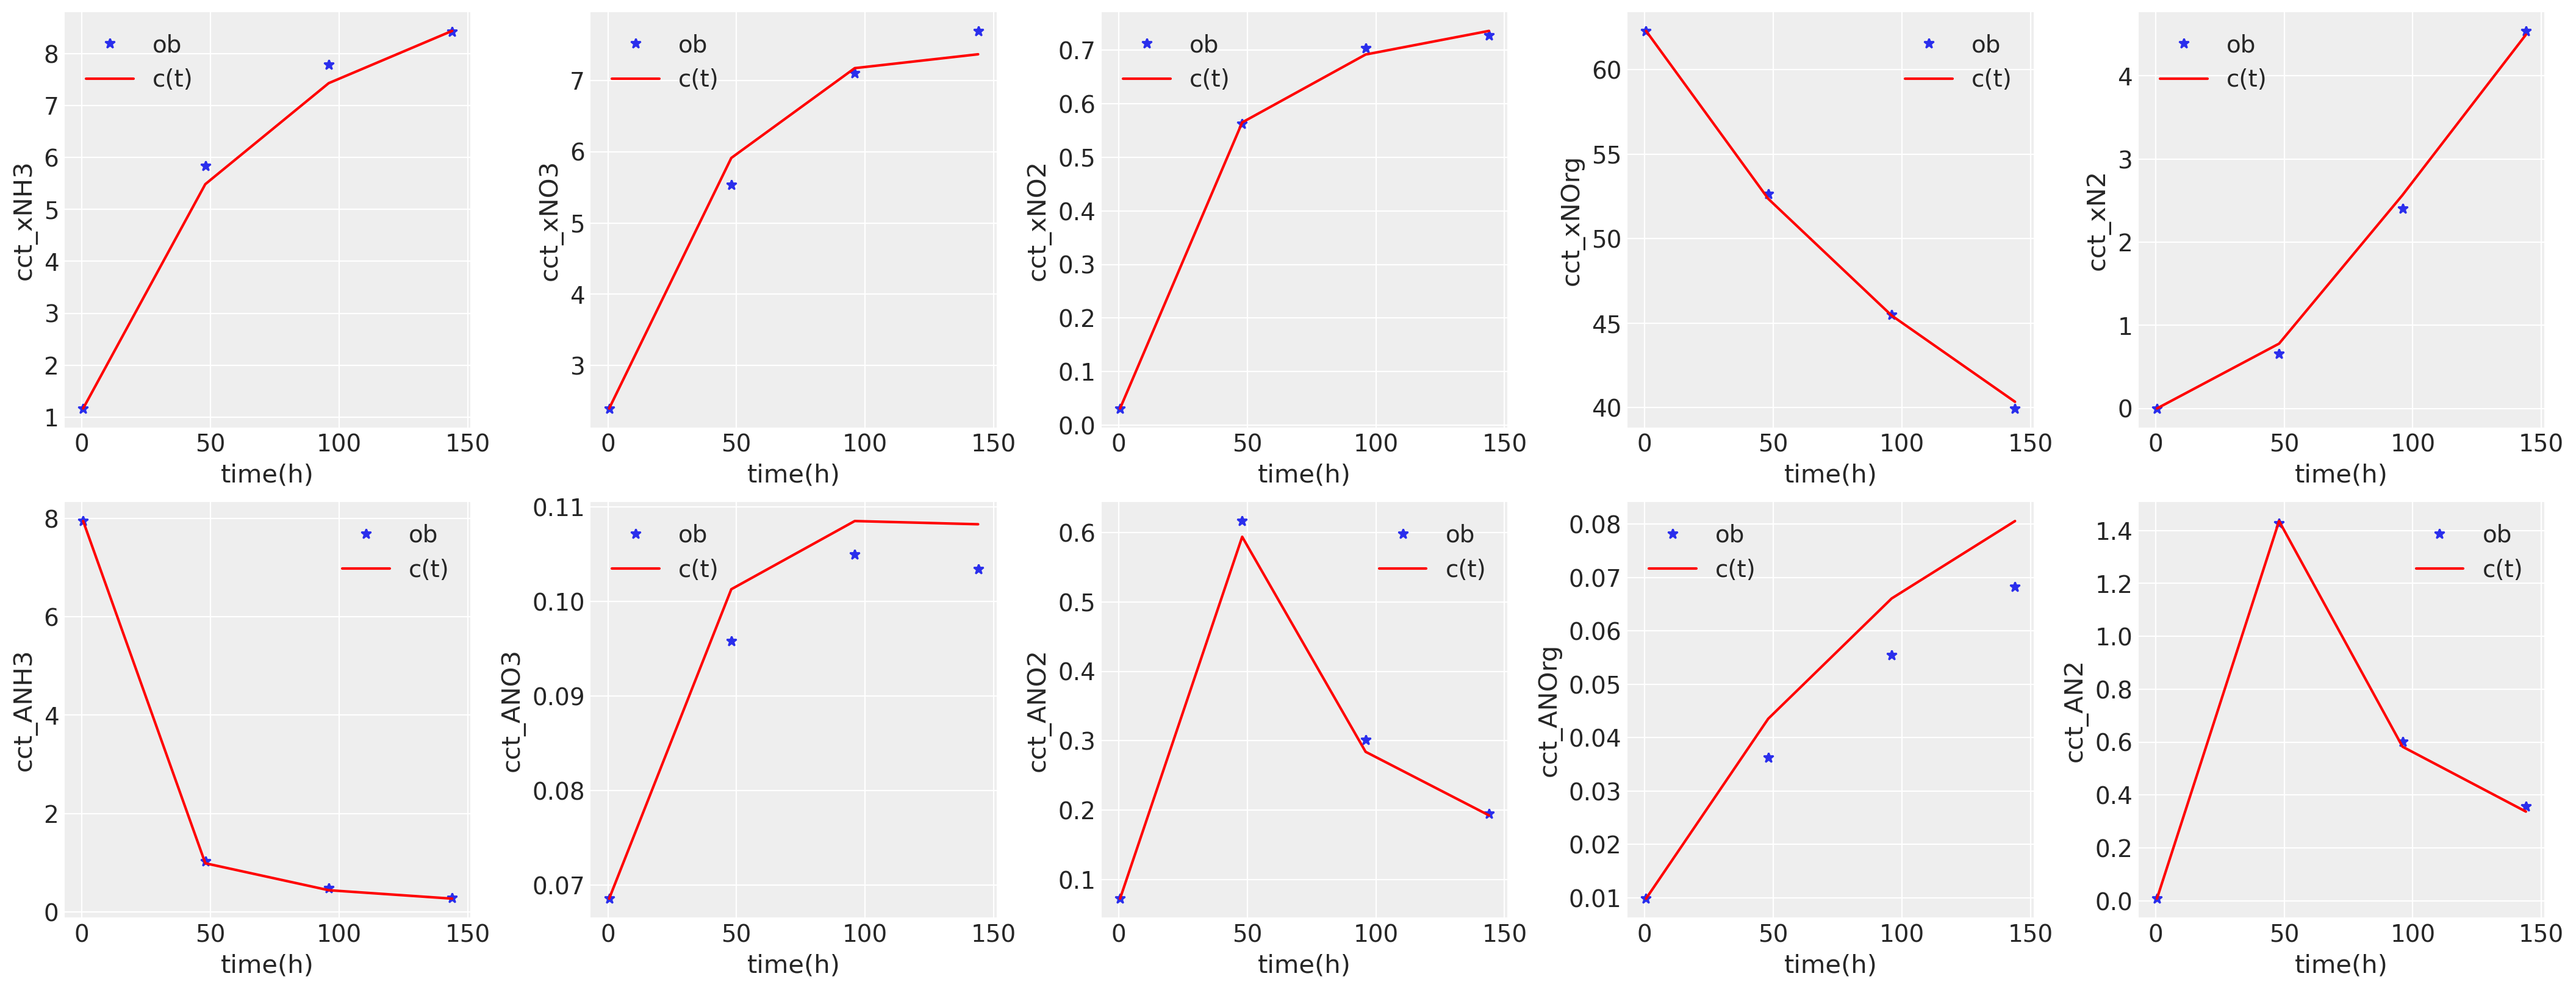

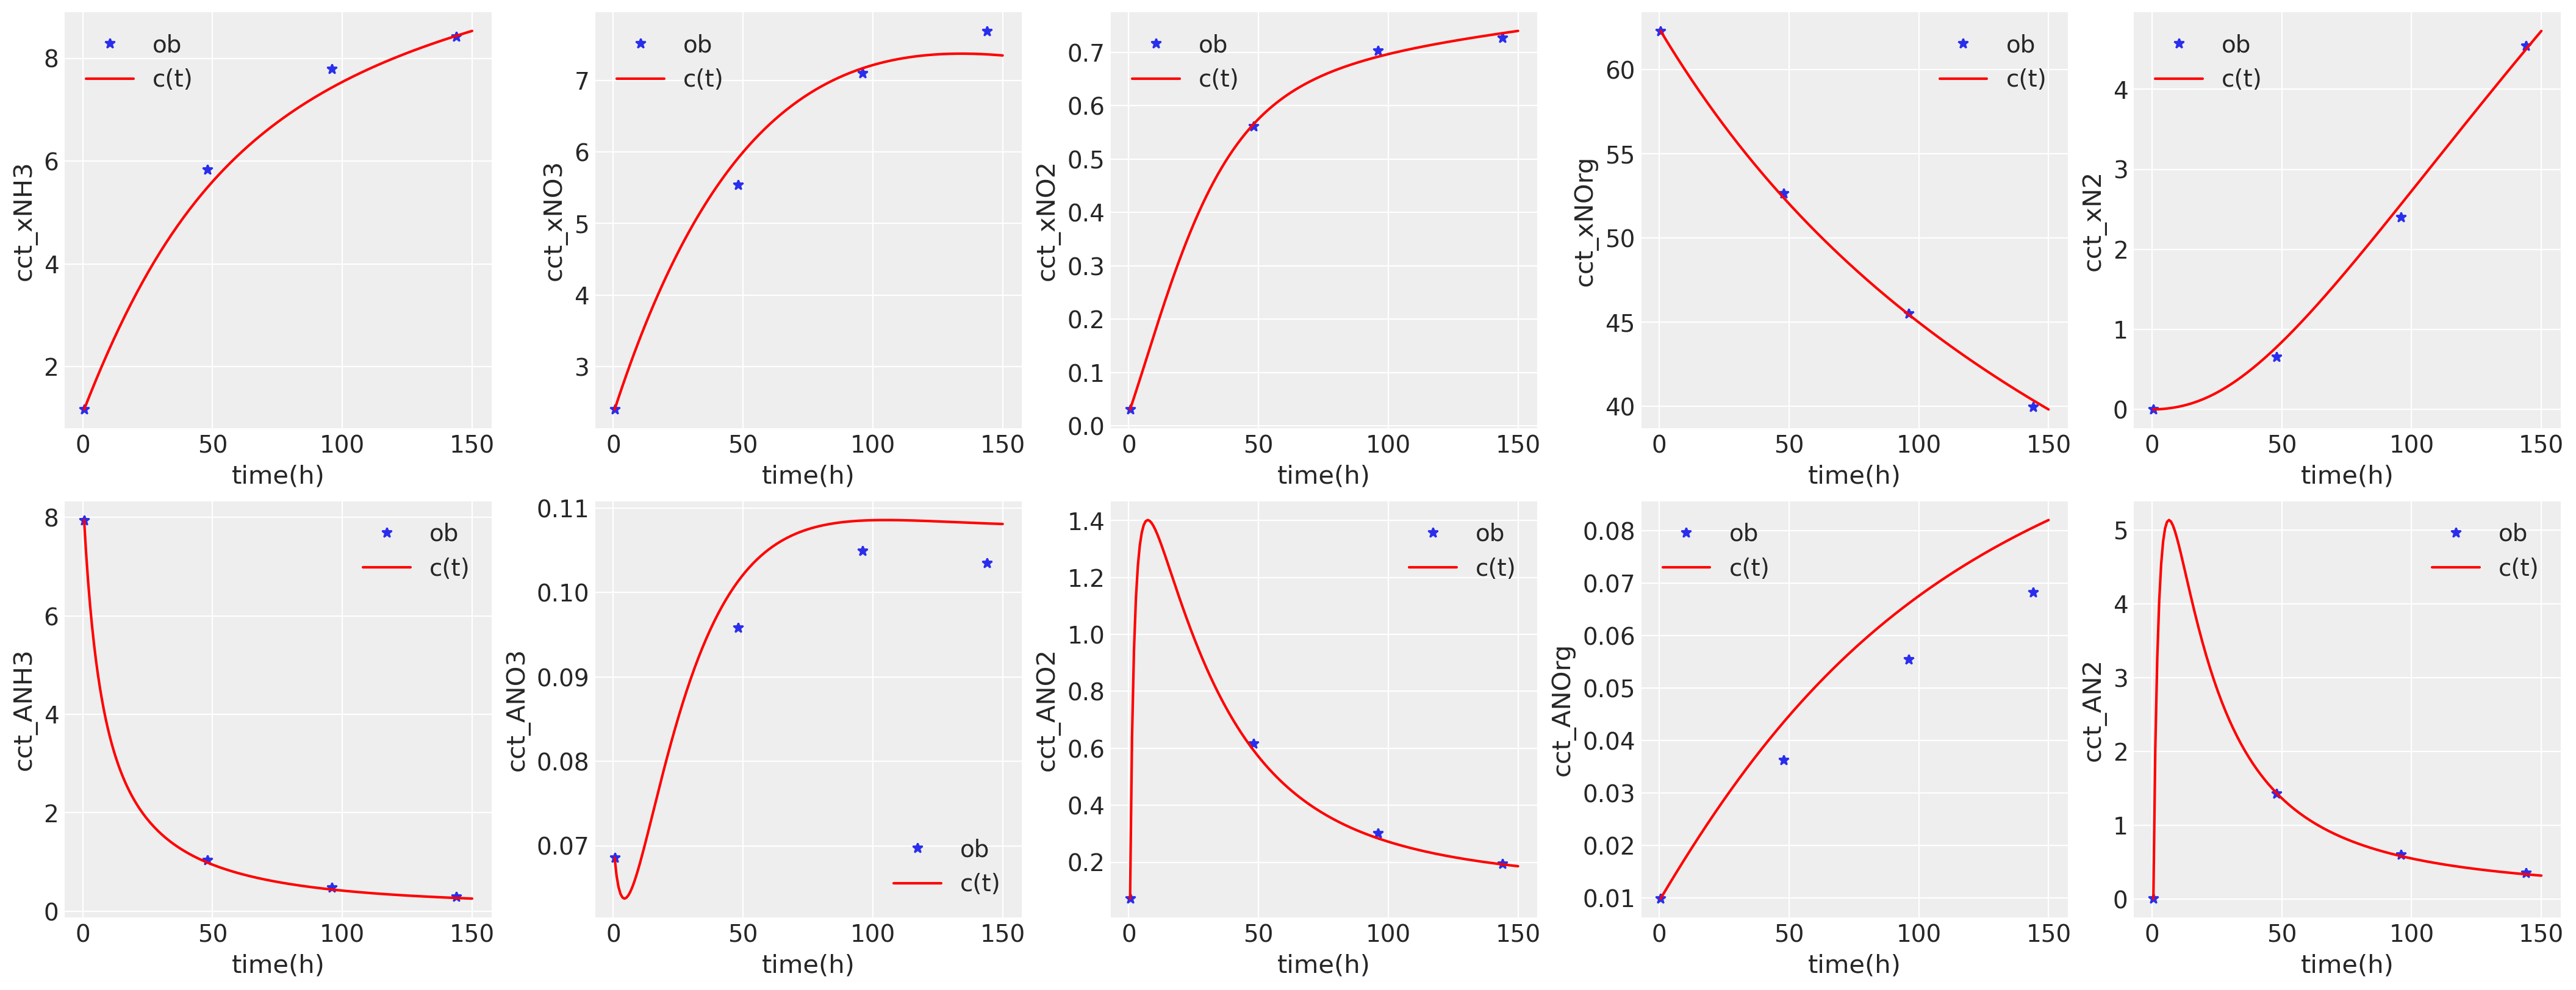

In [10]:
ks_predict = get_predict_ks(idata_lv)
k_kinetics = np.repeat(1, 11).astype(np.uint8)
t_eval = np.array([0.5, 48, 96, 144])

dataset_new = MyDataset(db_csv_path)
cct_names, rates_names, error_names = dataset_new.get_var_col_names()
gt_s = dataset_new.get_cct()[0]

dataset_new.set_as_sim_dataset(t_eval, gt_s, t0=0.5, args=(ks_predict, k_kinetics))
plot_dataset(dataset_sim, dataset_new)
# print("r2_loss", r2_loss(dataset_new.get_cct(), dataset.get_cct()))


t_eval_new = np.linspace(0.5, 150, 200)
dataset_new2 = MyDataset(db_csv_path)
dataset_new2.set_as_sim_dataset(t_eval_new, gt_s, t0=0.5, args=(ks_predict, k_kinetics))
plot_dataset(dataset_sim, dataset_new2)

print(ks_predict)

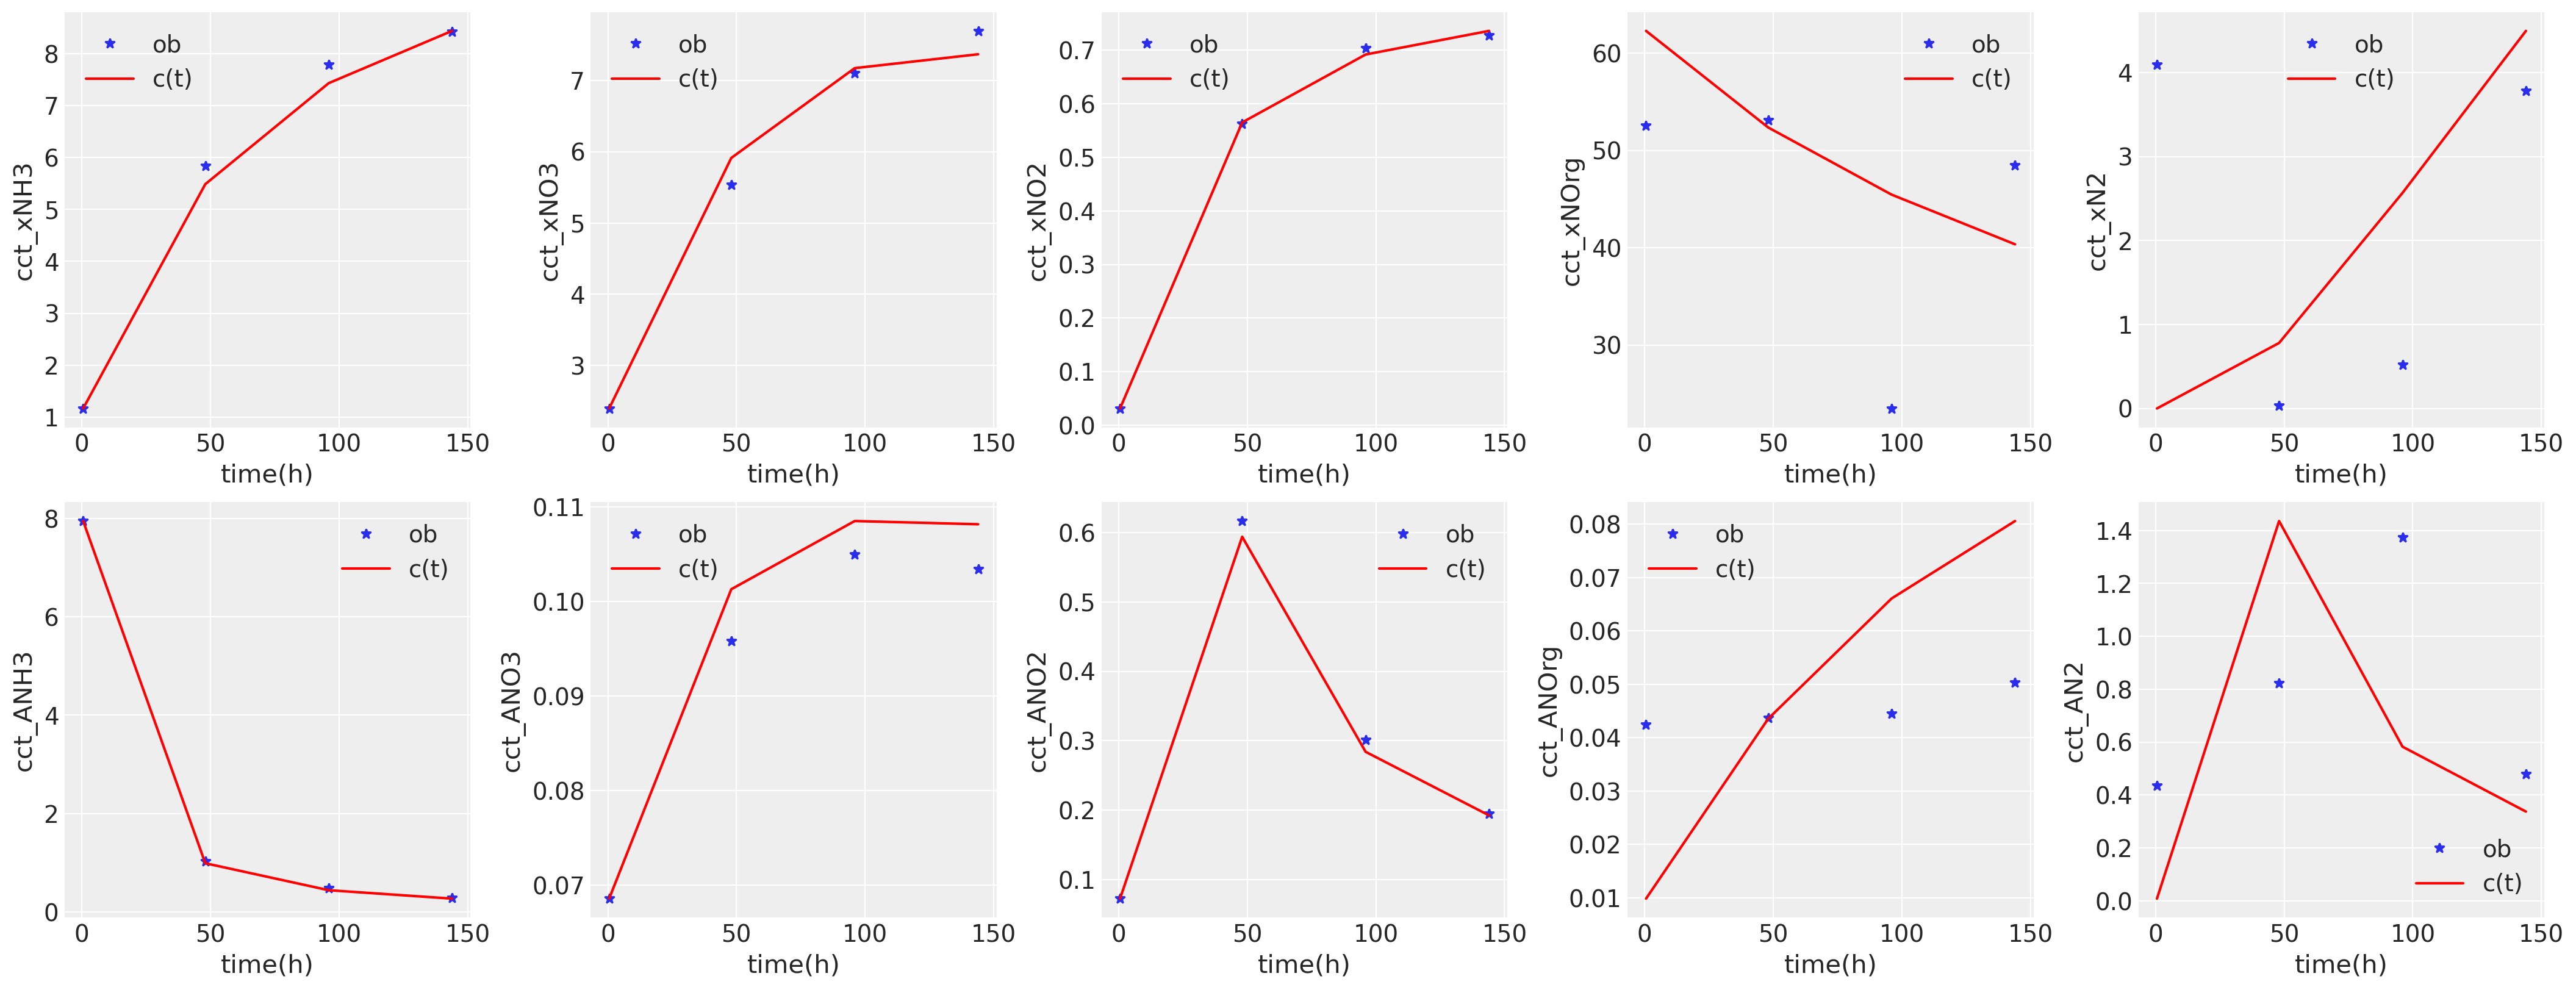

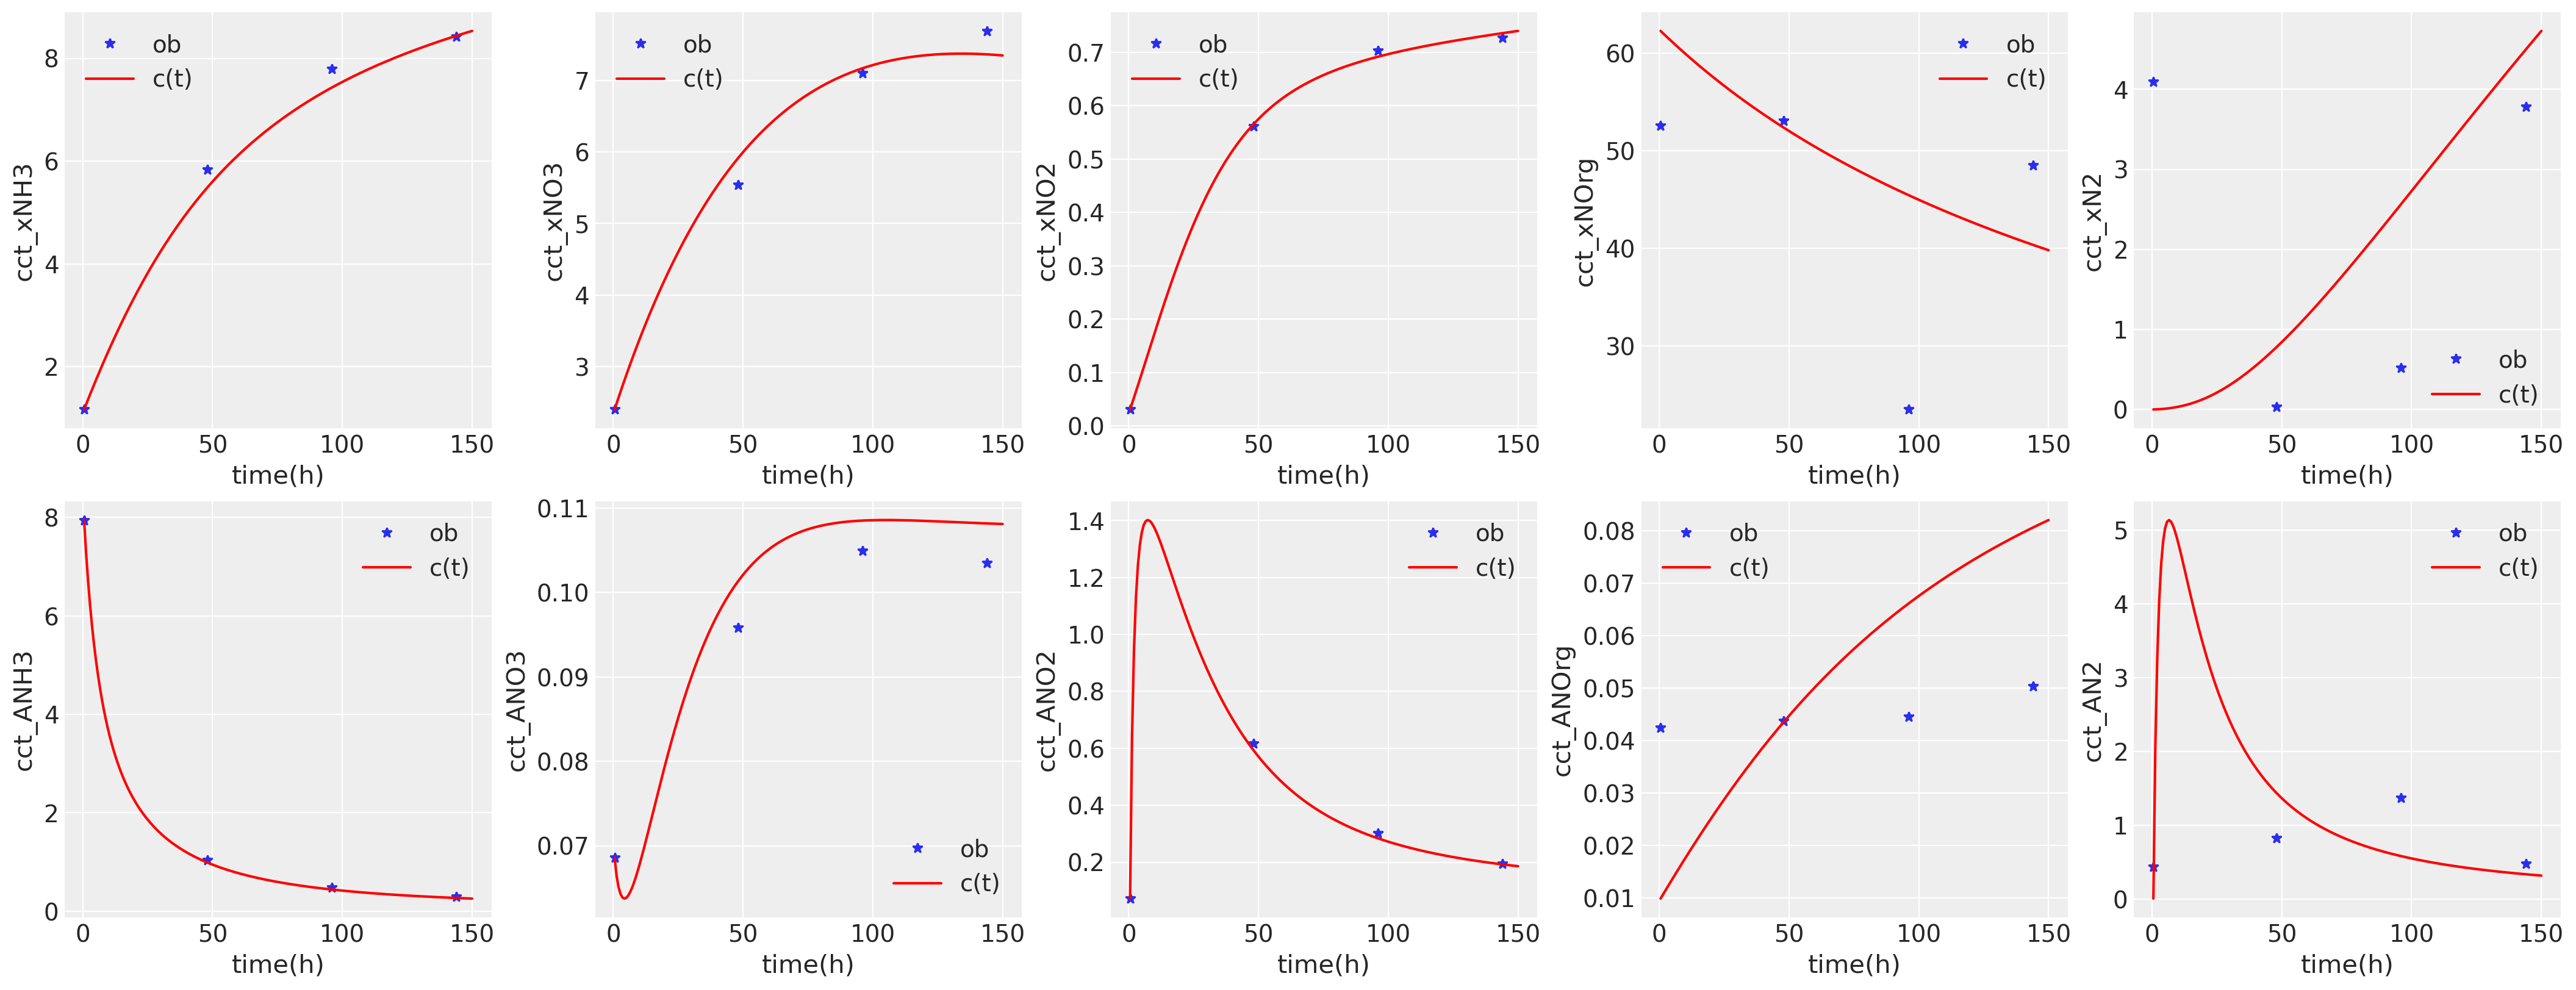

In [11]:
plot_dataset(dataset_fake, dataset_new)
plot_dataset(dataset_fake, dataset_new2)

In [13]:
ks_predict

array([0.00296455, 0.00351043, 0.00889154, 0.00493207, 0.00863788,
       0.00848131, 0.00356168, 0.00536778, 0.00551921, 0.00211468,
       0.00231901])